In this notebook I will determine the fiducial HOD parameters that are consistent with best-fits from the literature *and* is not impacted by the halo mass limit of the HADES and Quijote simulations. 

In [1]:
import os 
import scipy as sp 
import numpy as np 
# --- eMaNu --- 
from emanu import util as UT
from emanu import forwardmodel as FM
from emanu.hades import data as hadesData
# -- pyspectrum -- 
from pyspectrum import pyspectrum as pySpec
# --- corrfunc -- 
from Corrfunc.theory import wp as wpCF

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [3]:
# halo catalogs 
halos = hadesData.hadesMnuHalos(0., 1, 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1')
Mh_min = np.log10(np.array(halos['Mass']).min()) 
print('log(Mh_min) = %f' % Mh_min)
# hi res halo catalog
halos_hires = hadesData.hadesMnuHalos(0., '1_hires', 4, mh_min=None, dir='/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1_hires')

log(Mh_min) = 13.118305


In [50]:
def Ngal(tt, seed=0): 
    '''total number of galaxies populated in halos given HOD
    '''
    hod = FM.hodGalaxies(halos_hires, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    return len(np.array(hod['halo_mvir']))

def Ncutoff(tt, seed=0): 
    '''number of galaxies populated in halos below the halo mass limit 
    '''
    hod = FM.hodGalaxies(halos_hires, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    Ntot = len(np.array(hod['halo_mvir']))
    return np.sum(np.log10(np.array(hod['halo_mvir'])) < 13.118305), Ntot

def HMF_hod(tt, seed=0): 
    ''' halo mass function of halos with galaxies in them
    '''
    hod = FM.hodGalaxies(halos_hires, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    _logMh = np.log10(np.array(hod['halo_mvir']))
    _hmf, _logMhbin = np.histogram(_logMh, bins=20, range=[12., 16])
    return 0.5*(_logMhbin[1:] + _logMhbin[:-1]), _hmf

In [4]:
# Zheng et al. halo occupation functions 
def Ncen_Mh(tt, logMh): 
    ''' expected Ncen at Mh 
    '''
    logMmin, sig_logM, _, _, _ = tt
    Ncen = 0.5 * (1. + sp.special.erf((logMh - logMmin)/sig_logM)) 
    Ncen[~np.isfinite(Ncen)] = 0. 
    return Ncen

def Nsat_Mh(tt, logMh): 
    ''' expected Nsat at Mh
    '''
    _Ncen = Ncen_Mh(tt, logMh) 
    _, _, logM0, alpha, logM1 = tt
    Nsat = _Ncen * ((10**logMh - 10**logM0)/10**logM1)**alpha
    Nsat[~np.isfinite(Nsat)] = 0. 
    return Nsat 

def Ngal_Mh(tt, logMh): 
    return Ncen_Mh(tt, logMh) + Nsat_Mh(tt, logMh)

Here's how the best-fits from the literature compare to one another 

In [5]:
z07_21_5 = np.array([13.38, 0.51, 13.94, 1.04, 13.91]) # Zheng+(2007) Mr<-21.5
g15_21_5 = np.array([13.53, 0.72, 13.13, 1.14, 14.52]) # Guo+(2015) Mr<-21.5
v19_21_5 = np.array([13.39, 0.56, 12.87, 1.26, 14.51]) # Vakili+(2019) Mr<-21.5
z07_22_0 = np.array([14.22, 0.77, 14.00, 0.87, 14.69]) # Zheng+(2007) Mr<-22

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


(0.01, 50.0)

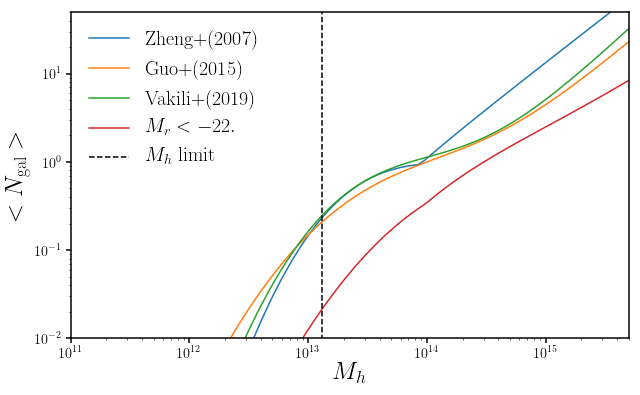

In [6]:
logMbin = np.linspace(11., 16., 100) # logMh bins

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(10**logMbin, Ngal_Mh(z07_21_5, logMbin), label='Zheng+(2007)')
sub.plot(10**logMbin, Ngal_Mh(g15_21_5, logMbin), label='Guo+(2015)')
sub.plot(10**logMbin, Ngal_Mh(v19_21_5, logMbin), label='Vakili+(2019)')
sub.plot(10**logMbin, Ngal_Mh(z07_22_0, logMbin), label='$M_r < -22.$')
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e3], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-2, 5e1)

Based on the halo mass limit, the $M_r < -21.5$ SDSS sample best-fit HODs cannot be used. Because of the large scatter, galaxies would have to reside in halos below $M_{\rm lim}$. Lets confirm this by comparing the galaxy clustering for the HODs using the regular simulations and higher resolution simulations. 

In [7]:
rbins = np.array([0.1, 0.15848932, 0.25118864, 0.39810717, 0.63095734, 1., 1.58489319, 2.51188643, 3.98107171, 6.30957344, 10., 15.84893192, 25.11886432]) 
def wp_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating wp 
    '''
    return np.loadtxt(f_wp(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def pk_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating Pk 
    '''
    return np.loadtxt(f_pk(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def f_wp(tt, res='HR', rsd=True, seed=None):
    wp_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'wp') 
    return os.path.join(wp_dir, 
            'wp.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))

def f_pk(tt, res='HR', rsd=True, seed=None): 
    ''' return file name for wp given HOD parameters
    '''
    pk_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'pk') 
    return os.path.join(pk_dir, 
            'pk.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))


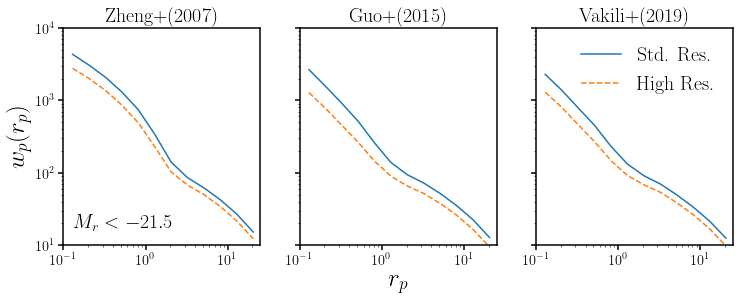

In [8]:
fig = plt.figure(figsize=(12,4))
for i, hod, lbl in zip(range(3), [z07_21_5, g15_21_5, v19_21_5], ['Zheng+(2007)', 'Guo+(2015)', 'Vakili+(2019)']): 
    sub = fig.add_subplot(1,3,i+1)
    
    _r, wp_lr = wp_model(hod, res='LR', rsd=True, seed=0) # low res
    _r, wp_hr = wp_model(hod, res='HR', rsd=True, seed=0) # high res 
    
    sub.plot(_r, wp_lr, c='C0', label='Std. Res.')
    sub.plot(_r, wp_hr, c='C1', ls='--', label='High Res.' )
    
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    sub.set_yscale('log') 
    sub.set_ylim(1e1, 1e4) 
    sub.set_title(lbl, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    else: sub.text(0.05, 0.05, r'$M_r < -21.5$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)

    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel('$w_p(r_p)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Text(0.05,0.05,'$M_r < -22$')

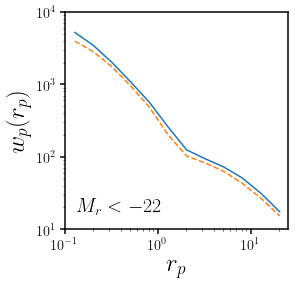

In [9]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)

_r, wp_lr = wp_model(z07_22_0, res='LR', rsd=True, seed=0) # low res
_r, wp_hr = wp_model(z07_22_0, res='HR', rsd=True, seed=0) # high res 

sub.plot(_r, wp_lr, c='C0', label='Std. Res.')
sub.plot(_r, wp_hr, c='C1', ls='--', label='High Res.' )
sub.set_xlabel('$r_p$', fontsize=25) 
sub.set_ylabel('$w_p(r_p)$', fontsize=25) 
sub.set_xscale('log') 
sub.set_xlim(1e-1, 25) 
sub.set_yscale('log') 
sub.set_ylim(1e1, 1e4) 
sub.text(0.05, 0.05, r'$M_r < -22$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)

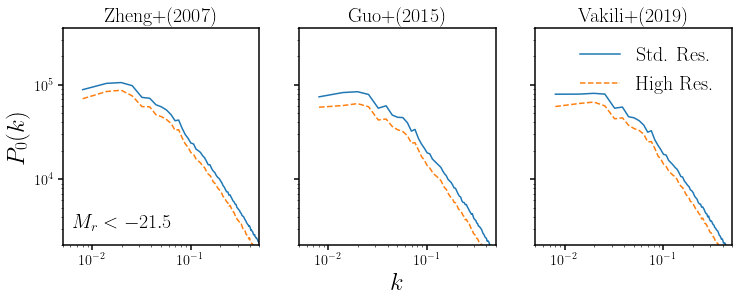

In [10]:
fig = plt.figure(figsize=(12,4))
for i, hod, lbl in zip(range(3), [z07_21_5, g15_21_5, v19_21_5], ['Zheng+(2007)', 'Guo+(2015)', 'Vakili+(2019)']): 
    sub = fig.add_subplot(1,3,i+1)
    
    k, pk_lr = pk_model(hod, res='LR', rsd=True, seed=0) # low res
    k, pk_hr = pk_model(hod, res='HR', rsd=True, seed=0) # high res 
    
    sub.plot(k, pk_lr, c='C0', label='Std. Res.')
    sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
    
    sub.set_xscale('log') 
    sub.set_xlim(5e-3, 0.5) 
    sub.set_yscale('log') 
    sub.set_ylim(2e3, 4e5) 
    sub.set_title(lbl, fontsize=20)
    if i != 0: sub.set_yticklabels([])
    else: sub.text(0.05, 0.05, r'$M_r < -21.5$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)
    if i == 2: sub.legend(loc='upper right', fontsize=20)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel('$P_0(k)$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

The halo mass limit in the standard resolution simulation removes central galaxies that would've been in lower mass halos. This messes up the bias of the clustering. Lets see how the $M_r < -22.0$ SDSS sample best-fit HOD does. 

Text(0.05,0.05,'$M_r < -22$')

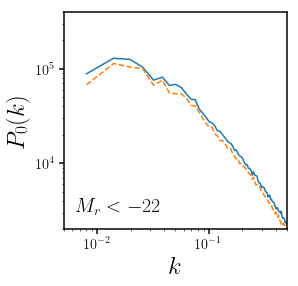

In [11]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)

k, pk_lr = pk_model(z07_22_0, res='LR', rsd=True, seed=0) # low res
k, pk_hr = pk_model(z07_22_0, res='HR', rsd=True, seed=0) # high res 

sub.plot(k, pk_lr, c='C0', label='Std. Res.')
sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
sub.set_xlabel('$k$', fontsize=25) 
sub.set_ylabel('$P_0(k)$', fontsize=25) 
sub.set_xscale('log') 
sub.set_xlim(5e-3, 0.5) 
sub.set_yscale('log') 
sub.set_ylim(2e3, 4e5) 
sub.text(0.05, 0.05, r'$M_r < -22$', ha='left', va='bottom', transform=sub.transAxes, fontsize=20)

In [13]:
print(np.median(pk_lr/pk_hr))

1.1780136322137231


The bias is less affected bny the halo mass limit in the $M_r < -22.$ SDSS sample best-fit. However, there is still a significant effect (~20% difference in amplitude). This means that even though the HOD will be less representative of a "naturally" observable sample, we will have to reduce $\sigma_{\log M}$. We also want to make sure that we preserve a similar number density as the halo sample to keep the signal high. Lets start with a fiducial with a tighter scatter and slightlky higher $M_{\rm min}, M_0, M_1$.

In [27]:
hod_fid = np.array([13.65, 0.2, 14., 1.1, 14.])

Here's how it compares to the Zheng et al. (2007) $M_r < -21$ and $M_r < -22$ best-fits

(0.01, 50.0)

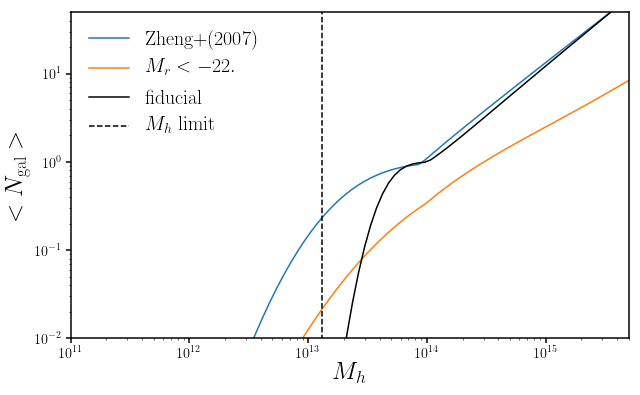

In [28]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(10**logMbin, Ngal_Mh(z07_21_5, logMbin), label='Zheng+(2007)')
sub.plot(10**logMbin, Ngal_Mh(z07_22_0, logMbin), label='$M_r < -22.$')
sub.plot(10**logMbin, Ngal_Mh(hod_fid, logMbin), label='fiducial', c='k')
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e3], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-2, 5e1)

(1, 100000.0)

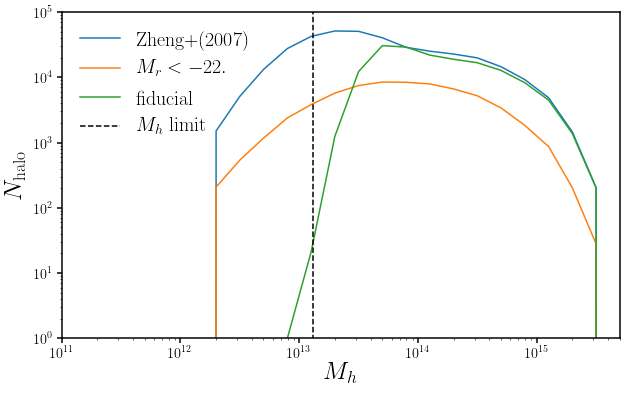

In [51]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
for _hod, lbl in zip([z07_21_5, z07_22_0, hod_fid], ['Zheng+(2007)', '$M_r < -22.$', 'fiducial']): 
    bin_hmf, hmf = HMF_hod(_hod, seed=0)
    sub.plot(10**bin_hmf, hmf, label=lbl)
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e10], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$N_{\rm halo}$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1, 1e5)

In [30]:
print('%i halos in the halo bispectrum paper' % np.sum(np.array(halos['Mass']) > 3.2*10**13))
ncuts, ngals = [], [] 
for i in range(10): 
    ncut, ngal = Ncutoff(hod_fid, seed=i)
    ncuts.append(ncut)
    ngals.append(ngal)
print('%i galaxies in the fiducial HOD' % np.average(ngals))
print('%i of them will be cut off by the Mh limit' % np.average(ncuts))

156160 halos in the halo bispectrum paper
158259 galaxies in the fiducial HOD
2 of them will be cut off by the Mh limit


Good. Barely any galaxies would fall in halos below the halo mass limit. Now as a sanity check lets check the clustering of the HOD catalog using standard versus high resolution sims. There's no point in scrutinizing the numbers because the halo clustering between the standard and high resolutions do not match perfectly so as long as they're in the similar ballpark we're good. 

(1.009003759835103, 1.0108496022256799)


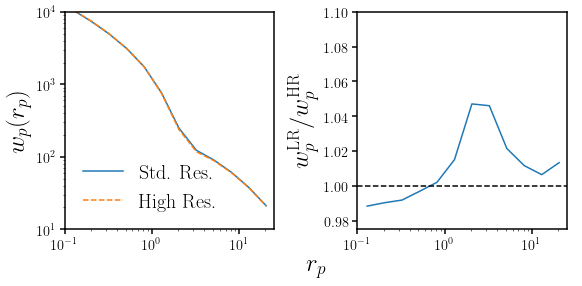

In [35]:
fig = plt.figure(figsize=(9,4))
wps_lr, wps_hr = [], []
for _ii in range(10): 
    _r, _wp_lr = wp_model(hod_fid, res='LR', rsd=True, seed=_ii) # low res
    _r, _wp_hr = wp_model(hod_fid, res='HR', rsd=True, seed=_ii) # high res 
    wps_lr.append(_wp_lr)
    wps_hr.append(_wp_hr)
wp_lr = np.average(wps_lr, axis=0)
wp_hr = np.average(wps_hr, axis=0)

print(np.median(wp_lr / wp_hr), np.average(wp_lr / wp_hr))

sub = fig.add_subplot(121)
sub.plot(_r, wp_lr, c='C0', label='Std. Res.')
sub.plot(_r, wp_hr, c='C1', ls='--', label='High Res.' )
sub.set_xscale('log') 
sub.set_xlim(1e-1, 25) 
sub.set_yscale('log') 
sub.set_ylim(1e1, 1e4) 
sub.set_ylabel('$w_p(r_p)$', fontsize=25) 
sub.legend(loc='lower left', fontsize=20)
        
sub = fig.add_subplot(122)
sub.plot(_r, wp_lr/wp_hr, c='C0')
sub.plot([1e-1, 25], [1., 1.], c='k', ls='--')
sub.set_xscale('log') 
sub.set_xlim(1e-1, 25) 
sub.set_ylim(0.975, 1.1) 
sub.set_ylabel(r'$w_p^{\rm LR}/w_p^{\rm HR}$', fontsize=25) 
        
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.4)

(1.0113340764588785, 1.009913021476057)
(0.9995589100906774, 0.9960380383548713)
(0.9980320487102723, 0.9963992907978843)
(0.9922588924761626, 0.990344642410359)


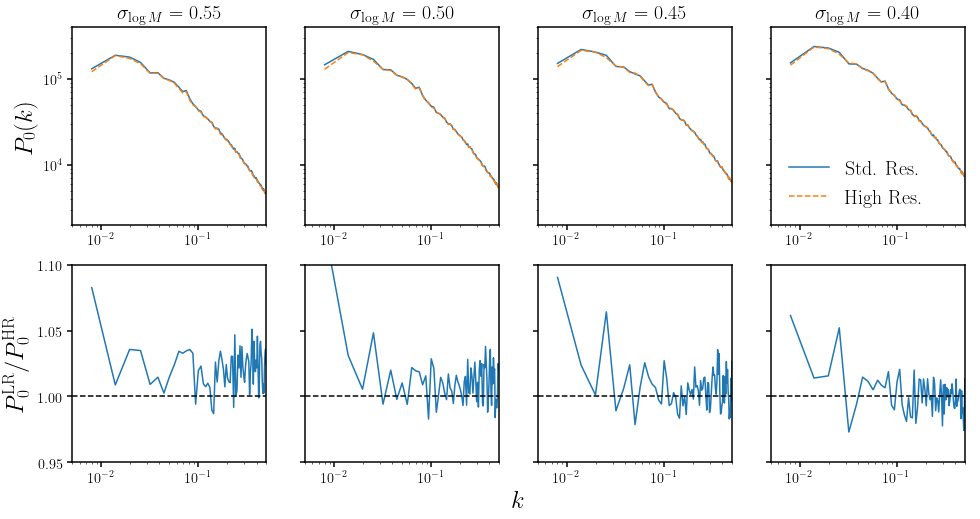

In [29]:
fig = plt.figure(figsize=(9,4))

pks_lr, pks_hr = [], []
for _ii in range(10): 
    k, _pk_lr = pk_model(tt_hod, res='LR', rsd=True, seed=_ii) # low res
    k, _pk_hr = pk_model(tt_hod, res='HR', rsd=True, seed=_ii) # high res  
    pks_lr.append(_pk_lr)
    pks_hr.append(_pk_hr)
pk_lr = np.average(pks_lr, axis=0)
pk_hr = np.average(pks_hr, axis=0)
    
sub = fig.add_subplot(121)
sub.plot(k, pk_lr, c='C0', label='Std. Res.')
sub.plot(k, pk_hr, c='C1', ls='--', label='High Res.' )
print(np.median(pk_lr / pk_hr), np.average(pk_lr / pk_hr))
sub.set_xscale('log') 
sub.set_xlim(5e-3, 0.5) 
sub.set_yscale('log') 
sub.set_ylim(2e3, 4e5) 
sub.set_ylabel('$P_0(k)$', fontsize=25) 
sub.legend(loc='lower left', fontsize=20)

sub = fig.add_subplot(2,4,i+5)
sub.plot(k, pk_lr/pk_hr, c='C0')
sub.plot([5e-3, 0.5], [1., 1.], c='k', ls='--')
sub.set_xscale('log') 
sub.set_xlim(5e-3, 0.5) 
sub.set_ylim(0.95, 1.1) 
sub.set_ylabel(r'$P_0^{\rm LR}/P_0^{\rm HR}$', fontsize=25) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.4)

The clustering of the standard and high resolution HOD catalogs are reasonably in agreement. In addition, very few galaxies would fall into halos below $M_{\rm lim}$. Hence a sensible choicse for our fiducial HOD parameters would be something like: 

$\log M_{\rm min} = 13.65$

$\sigma_{\log M} = 0.2$ 

$\log M_0 = 14$

$\alpha = 1.1$

$\log M_1 = 14$